In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna

warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-all/train_all/train_all.csv')
test_df = pd.read_csv('/kaggle/input/data-all/train_all/test_all.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

## Hàm bổ trợ

In [7]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, top_features=None):
    model_rf = RandomForestClassifier(random_state=42)
    
    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_rf.fit(X_train, y_train)
    
    y_pred = model_rf.predict(X_test)
    
    print_scores(y_test, y_pred)

In [9]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, top_features=None):
    # Tối ưu hóa các tham số cho Random Forest
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = RandomForestClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán xác suất và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [10]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       top_features=None,
                       n_trials=20, timeout=1200):  
    study = optuna.create_study(direction='maximize')
    
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, top_features),
                   n_trials=n_trials, timeout=timeout)

    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_state': 42,
        'n_jobs': -1
    })
    
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

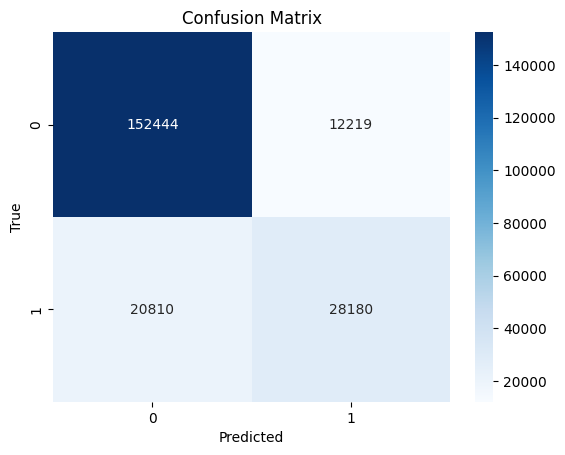

              precision    recall  f1-score   support

           0       0.88      0.93      0.90    164663
           1       0.70      0.58      0.63     48990

    accuracy                           0.85    213653
   macro avg       0.79      0.75      0.77    213653
weighted avg       0.84      0.85      0.84    213653



In [11]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 17:43:00,337] A new study created in memory with name: no-name-f6e8b0dc-e423-4abb-8450-0c2616810b8d
[I 2025-05-05 17:47:28,828] Trial 0 finished with value: 0.5552995098351263 and parameters: {'n_estimators': 259, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.8}. Best is trial 0 with value: 0.5552995098351263.
[I 2025-05-05 17:52:30,046] Trial 1 finished with value: 0.65856388933312 and parameters: {'n_estimators': 291, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.35}. Best is trial 1 with value: 0.65856388933312.
[I 2025-05-05 17:56:40,987] Trial 2 finished with value: 0.6199462090442849 and parameters: {'n_estimators': 243, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.35}. Best is trial 1

Best trial:
FrozenTrial(number=1, state=1, values=[0.65856388933312], datetime_start=datetime.datetime(2025, 5, 5, 17, 47, 28, 829340), datetime_complete=datetime.datetime(2025, 5, 5, 17, 52, 30, 45688), params={'n_estimators': 291, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=1, value=None)
Best hyperparameters:
n_estima

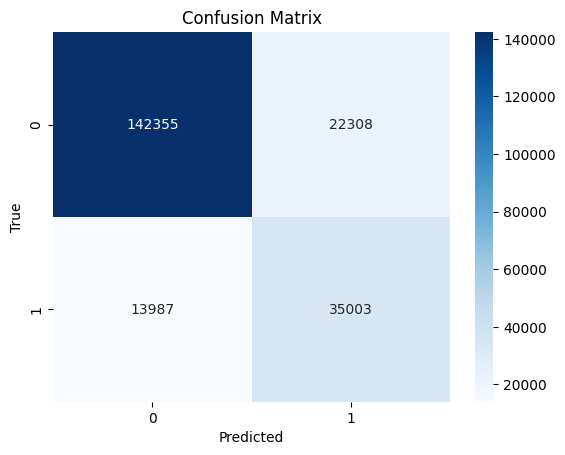

              precision    recall  f1-score   support

           0       0.91      0.86      0.89    164663
           1       0.61      0.71      0.66     48990

    accuracy                           0.83    213653
   macro avg       0.76      0.79      0.77    213653
weighted avg       0.84      0.83      0.83    213653



In [12]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

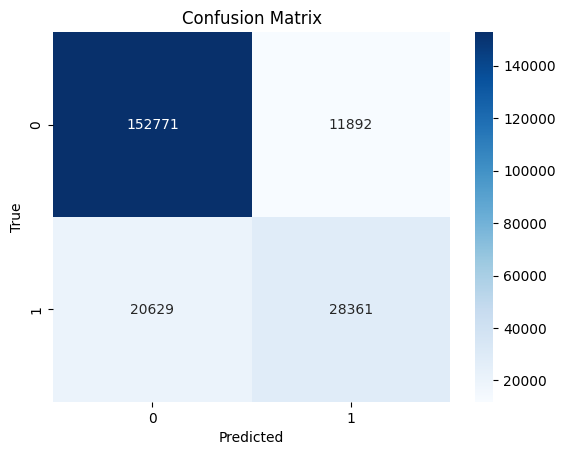

              precision    recall  f1-score   support

           0       0.88      0.93      0.90    164663
           1       0.70      0.58      0.64     48990

    accuracy                           0.85    213653
   macro avg       0.79      0.75      0.77    213653
weighted avg       0.84      0.85      0.84    213653



In [13]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 18:12:57,808] A new study created in memory with name: no-name-c51f52f8-64ae-4fee-9e30-9426253743d5
[I 2025-05-05 18:14:44,848] Trial 0 finished with value: 0.3465304798962387 and parameters: {'n_estimators': 135, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.3465304798962387.
[I 2025-05-05 18:17:28,035] Trial 1 finished with value: 0.5866306310857403 and parameters: {'n_estimators': 225, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.30000000000000004}. Best is trial 1 with value: 0.5866306310857403.
[I 2025-05-05 18:20:44,463] Trial 2 finished with value: 0.6024423337856174 and parameters: {'n_estimators': 253, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', '

Best trial:
FrozenTrial(number=7, state=1, values=[0.673099661315858], datetime_start=datetime.datetime(2025, 5, 5, 18, 28, 38, 112361), datetime_complete=datetime.datetime(2025, 5, 5, 18, 30, 36, 282757), params={'n_estimators': 212, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=7, value=None)
Best hyperparameters:
n_estim

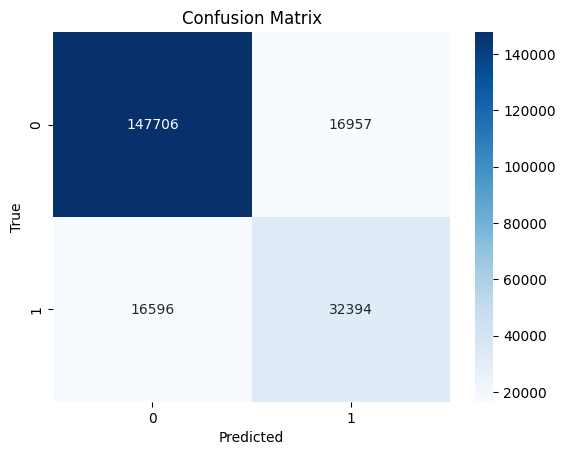

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    164663
           1       0.66      0.66      0.66     48990

    accuracy                           0.84    213653
   macro avg       0.78      0.78      0.78    213653
weighted avg       0.84      0.84      0.84    213653



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

# SMOTE

In [15]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

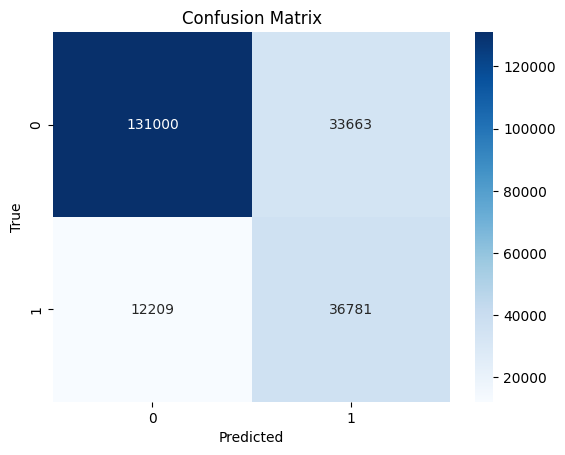

              precision    recall  f1-score   support

           0       0.91      0.80      0.85    164663
           1       0.52      0.75      0.62     48990

    accuracy                           0.79    213653
   macro avg       0.72      0.77      0.73    213653
weighted avg       0.82      0.79      0.80    213653



In [16]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 18:54:31,197] A new study created in memory with name: no-name-2c2935a1-e49f-46b4-8625-22139125b75a
[I 2025-05-05 19:01:03,779] Trial 0 finished with value: 0.6396118355770508 and parameters: {'n_estimators': 164, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}. Best is trial 0 with value: 0.6396118355770508.
[I 2025-05-05 19:13:51,671] Trial 1 finished with value: 0.4159202833856522 and parameters: {'n_estimators': 300, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.8}. Best is trial 0 with value: 0.6396118355770508.
[I 2025-05-05 19:21:39,933] Trial 2 finished with value: 0.1359291772610011 and parameters: {'n_estimators': 195, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.9}. Best is tria

Best trial:
FrozenTrial(number=0, state=1, values=[0.6396118355770508], datetime_start=datetime.datetime(2025, 5, 5, 18, 54, 31, 199311), datetime_complete=datetime.datetime(2025, 5, 5, 19, 1, 3, 779106), params={'n_estimators': 164, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=0, value=None)
Best hyperparameters:
n_estim

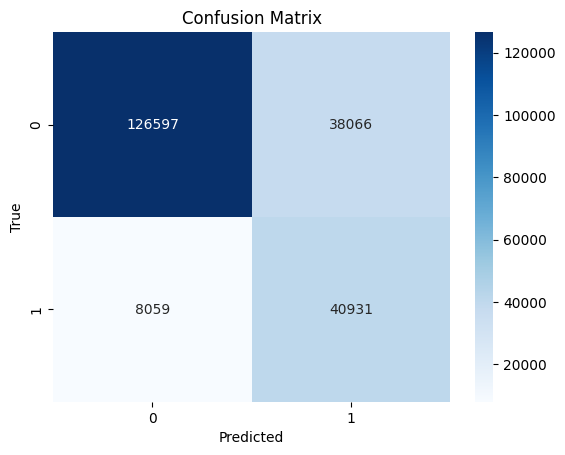

              precision    recall  f1-score   support

           0       0.94      0.77      0.85    164663
           1       0.52      0.84      0.64     48990

    accuracy                           0.78    213653
   macro avg       0.73      0.80      0.74    213653
weighted avg       0.84      0.78      0.80    213653



In [17]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

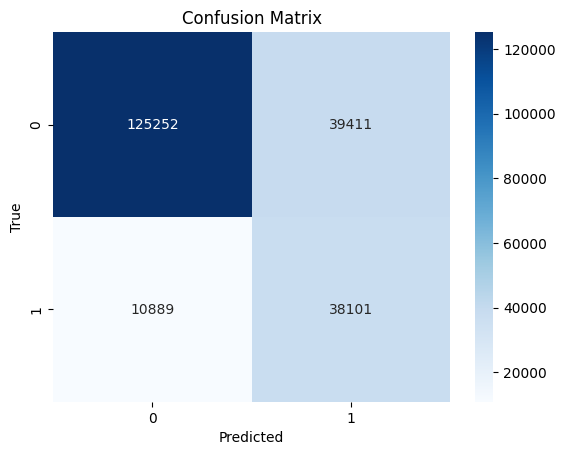

              precision    recall  f1-score   support

           0       0.92      0.76      0.83    164663
           1       0.49      0.78      0.60     48990

    accuracy                           0.76    213653
   macro avg       0.71      0.77      0.72    213653
weighted avg       0.82      0.76      0.78    213653



In [18]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 19:36:41,726] A new study created in memory with name: no-name-3ebf0832-cf2f-4075-8a70-ce4654569c55
[I 2025-05-05 19:42:38,960] Trial 0 finished with value: 0.5639372864516441 and parameters: {'n_estimators': 199, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.35}. Best is trial 0 with value: 0.5639372864516441.
[I 2025-05-05 19:49:51,862] Trial 1 finished with value: 0.6194362548376074 and parameters: {'n_estimators': 239, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}. Best is trial 1 with value: 0.6194362548376074.
[I 2025-05-05 19:57:53,524] Trial 2 finished with value: 0.4623608740021554 and parameters: {'n_estimators': 291, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.150000000000000

Best trial:
FrozenTrial(number=1, state=1, values=[0.6194362548376074], datetime_start=datetime.datetime(2025, 5, 5, 19, 42, 38, 961059), datetime_complete=datetime.datetime(2025, 5, 5, 19, 49, 51, 862184), params={'n_estimators': 239, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=1, value=None)
Best hyperparameters:
n_est

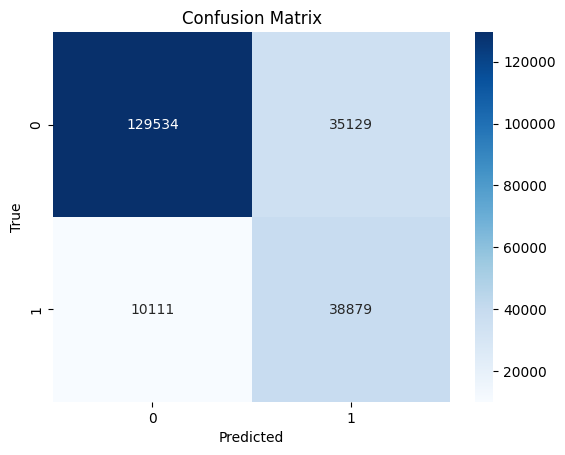

              precision    recall  f1-score   support

           0       0.93      0.79      0.85    164663
           1       0.53      0.79      0.63     48990

    accuracy                           0.79    213653
   macro avg       0.73      0.79      0.74    213653
weighted avg       0.84      0.79      0.80    213653



In [19]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [20]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

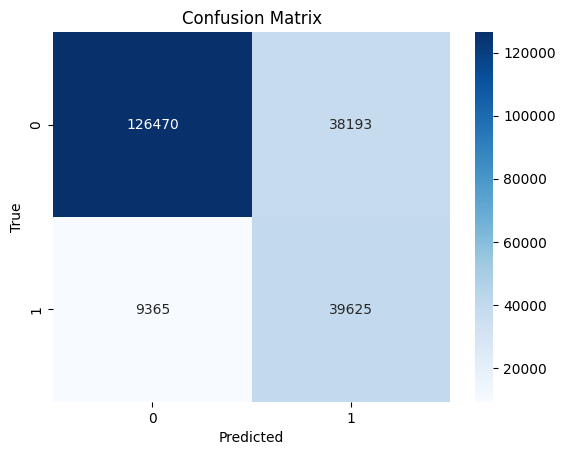

              precision    recall  f1-score   support

           0       0.93      0.77      0.84    164663
           1       0.51      0.81      0.62     48990

    accuracy                           0.78    213653
   macro avg       0.72      0.79      0.73    213653
weighted avg       0.83      0.78      0.79    213653



In [21]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 20:45:13,885] A new study created in memory with name: no-name-09b4fb7c-c4c9-4ab7-8c71-da2339637aa6
[I 2025-05-05 20:52:10,110] Trial 0 finished with value: 0.5353341143629097 and parameters: {'n_estimators': 298, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.5353341143629097.
[I 2025-05-05 20:55:56,613] Trial 1 finished with value: 0.6397227555846953 and parameters: {'n_estimators': 120, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}. Best is trial 1 with value: 0.6397227555846953.
[I 2025-05-05 21:01:48,238] Trial 2 finished with value: 0.5969666356331175 and parameters: {'n_estimators': 144, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.

Best trial:
FrozenTrial(number=1, state=1, values=[0.6397227555846953], datetime_start=datetime.datetime(2025, 5, 5, 20, 52, 10, 111880), datetime_complete=datetime.datetime(2025, 5, 5, 20, 55, 56, 613228), params={'n_estimators': 120, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=1, value=None)
Best hyperparameters:
n_est

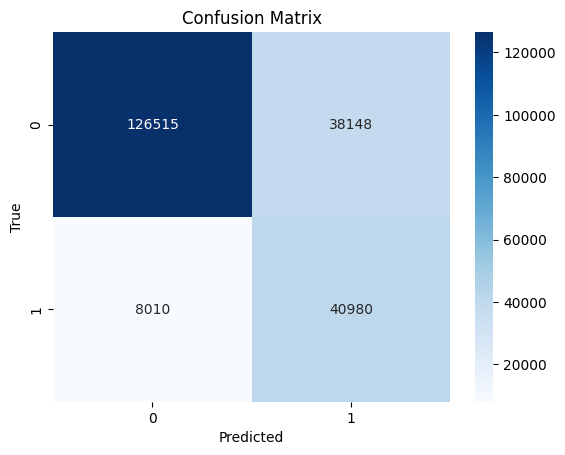

              precision    recall  f1-score   support

           0       0.94      0.77      0.85    164663
           1       0.52      0.84      0.64     48990

    accuracy                           0.78    213653
   macro avg       0.73      0.80      0.74    213653
weighted avg       0.84      0.78      0.80    213653



In [22]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

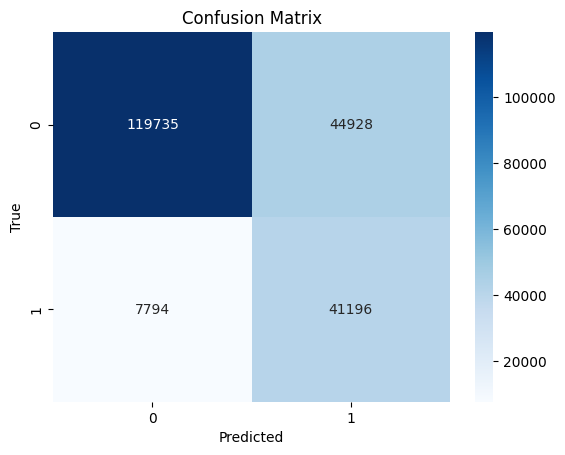

              precision    recall  f1-score   support

           0       0.94      0.73      0.82    164663
           1       0.48      0.84      0.61     48990

    accuracy                           0.75    213653
   macro avg       0.71      0.78      0.71    213653
weighted avg       0.83      0.75      0.77    213653



In [23]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 21:18:09,281] A new study created in memory with name: no-name-5f71809c-9867-4188-acfd-66174b21b0e7
[I 2025-05-05 21:20:56,234] Trial 0 finished with value: 0.4436959141198379 and parameters: {'n_estimators': 173, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.1}. Best is trial 0 with value: 0.4436959141198379.
[I 2025-05-05 21:24:00,921] Trial 1 finished with value: 0.5944018660446518 and parameters: {'n_estimators': 138, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}. Best is trial 1 with value: 0.5944018660446518.
[I 2025-05-05 21:27:17,375] Trial 2 finished with value: 0.6168219015448108 and parameters: {'n_estimators': 201, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6

Best trial:
FrozenTrial(number=3, state=1, values=[0.6236150729273188], datetime_start=datetime.datetime(2025, 5, 5, 21, 27, 17, 376509), datetime_complete=datetime.datetime(2025, 5, 5, 21, 32, 54, 136700), params={'n_estimators': 234, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=3, value=None)
Best hyperparameters:
n_est

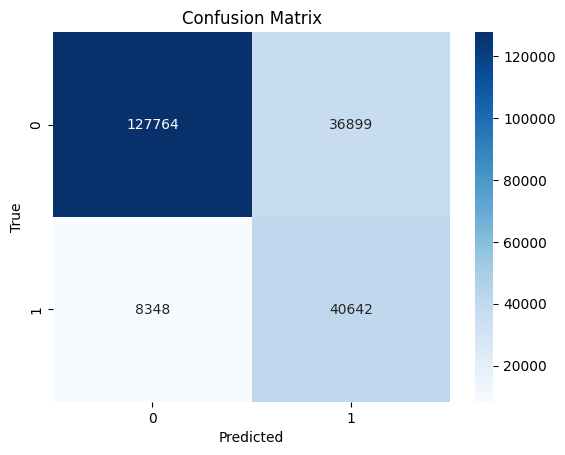

              precision    recall  f1-score   support

           0       0.94      0.78      0.85    164663
           1       0.52      0.83      0.64     48990

    accuracy                           0.79    213653
   macro avg       0.73      0.80      0.75    213653
weighted avg       0.84      0.79      0.80    213653



In [24]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)